In [1]:
!pip install -q Pillow gdown

### Importing required libraries

In [2]:
import gdown
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import json
import os
import shutil

import torchvision
import numpy as np
import pandas as pd 
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import nltk

In [3]:
def delete_files(arr):
    for file_path in arr:
        if os.path.exists(file_path):
            os.remove(file_path)

In [4]:

def delete_folders(arr):
    for folder_path in arr:
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)

## Data downloading, preprocessing and analyzing

CNN Model

In [5]:
gdown.download("https://drive.google.com/u/0/uc?export=download&confirm=X2sC&id=1TlNmpLUBw7jJEXgpliy29Am1HpHl-KNJ", "beheaded_inception3.py", True)

'beheaded_inception3.py'

### Downloading the MS COCO Dataset

**Images download**

In [6]:
%%time
!wget -q http://images.cocodataset.org/zips/train2014.zip
print("Unzipping...")
!unzip -q train2014.zip

Unzipping...
CPU times: user 1.17 s, sys: 204 ms, total: 1.37 s
Wall time: 11min 35s


In [7]:
delete_files(["/content/train2014.zip"])

**Captions download**

In [8]:

%%time
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
print("Unzipping...")
!unzip -q annotations_trainval2014.zip

--2021-02-05 21:32:46--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.177.123
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.177.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  44.8MB/s    in 5.8s    

2021-02-05 21:32:52 (41.3 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

Unzipping...
CPU times: user 52.8 ms, sys: 25 ms, total: 77.9 ms
Wall time: 13.4 s


In [9]:
delete_files([
    "/content/annotations/instances_train2014.json",
    "/content/annotations/instances_val2014.json",
    "/content/annotations/person_keypoints_train2014.json",
    "/content/annotations/person_keypoints_val2014.json",
])

### Data preprocessing

In [10]:
data = json.load(open("/content/annotations/captions_train2014.json"))

In [11]:
def data_table(keys):
    dataframes = []

    for key in keys:

        if key == img_key:
            key_value = "file_name"
            key_id = "id"
        elif key == caption_key:
            key_value = "caption"
            key_id = "image_id"

        data_dict = {}
        data_dict[key_value] = []
        data_dict["id"] = []

        for item in data[key]:
            data_dict[key_value].append(item[key_value])
            data_dict["id"].append(item[key_id])

        dataframes.append(pd.DataFrame(data=data_dict))

    return pd.merge(dataframes[0], dataframes[1], on=("id"))

**Get rid of redundant data columns**

In [12]:
%%time
img_key = "images"
caption_key = "annotations"

df = data_table((img_key, caption_key))

CPU times: user 392 ms, sys: 13.5 ms, total: 405 ms
Wall time: 484 ms


In [13]:
df.drop(columns="id", inplace=True)
df.rename(columns={"file_name": "image"}, inplace=True)

In [14]:
df.head()

,image,caption
0,COCO_train2014_000000057870.jpg,A restaurant has modern wooden tables and chairs.
1,COCO_train2014_000000057870.jpg,A long restaurant table with rattan rounded ba...
2,COCO_train2014_000000057870.jpg,a long table with a plant on top of it surroun...
3,COCO_train2014_000000057870.jpg,A long table with a flower arrangement in the ...
4,COCO_train2014_000000057870.jpg,A table is adorned with wooden chairs with blu...


In [15]:
df = df[df['image'].isin(os.listdir("/content/train2014"))]
df.reset_index(drop=True, inplace=True)

In [16]:
df

,image,caption
0,COCO_train2014_000000057870.jpg,A restaurant has modern wooden tables and chairs.
1,COCO_train2014_000000057870.jpg,A long restaurant table with rattan rounded ba...
2,COCO_train2014_000000057870.jpg,a long table with a plant on top of it surroun...
3,COCO_train2014_000000057870.jpg,A long table with a flower arrangement in the ...
4,COCO_train2014_000000057870.jpg,A table is adorned with wooden chairs with blu...
...,...,...
414108,COCO_train2014_000000475546.jpg,The patrons enjoy their beverages at the bar.
414109,COCO_train2014_000000475546.jpg,People having a drink in a basement bar.
414110,COCO_train2014_000000475546.jpg,A group of friends enjoys a drink while sittin...
414111,COCO_train2014_000000475546.jpg,Group of people drinking wine at a public loca...


-- Empty table data check --

In [17]:
df.isna().any()

image      False
caption    False
dtype: bool

## Creating datasets, iterators

In [18]:
IMAGE_COL_LABEL = df.columns[0]
CAPTION_COL_LABEL = df.columns[1]

In [19]:
import string

class TextDataset(Dataset):
    
    BOS = "<BOS>"
    EOS = "<EOS>"
    PAD = "<PAD>"

    def __init__(self, text_data: pd.Series, min_word_freq=None, max_word_freq=None, max_sentence_len=20, lower=True):

        if min_word_freq is None:
            self.min_word_freq = -np.inf
        else:
            self.min_word_freq = min_word_freq

        if max_word_freq is None:
            self.max_word_freq = np.inf
        else:
            self.max_word_freq = max_word_freq


        self.max_sentence_len = max_sentence_len
        self.lower = lower

        self.tokenizer = nltk.WordPunctTokenizer()
        self.additional_tokens = set([self.BOS, self.EOS, self.PAD])
        self.token2idx = {self.BOS: 1, self.EOS: 2, self.PAD: 0}

        self.vocab = set(self.append_words(text_data))
        self.token2idx.update({token:num + len(self.additional_tokens) for num, token in enumerate(self.vocab) if token not in self.additional_tokens})

        self.idx2token = {num: token for token, num in self.token2idx.items()}
        self.vocab = self.additional_tokens.union(self.vocab)

    def __len__(self):
        return len(self.vocab)

    def __getitem__(self, text):            
        tokens = self.__tokenize(text)
        text_ids = [token for token in tokens if token in self.vocab]
        text_ids = self.pad_sequence(text_ids)        
        text_ids = [self.token2idx[token] for token in text_ids]
        return text_ids

    def __tokenize(self, row):
        cut_edge = self.max_sentence_len - 2

        row = row.lower() if self.lower else row
        tokens = self.tokenizer.tokenize(row)
        tokens = [token for token in tokens if token not in string.punctuation]
        tokens = tokens[:cut_edge]
        tokens = [self.BOS] + tokens + [self.EOS]
        tokens = self.pad_sequence(tokens)
        return tokens

    def pad_sequence(self, tokens):
        padded_sequence = tokens + (self.max_sentence_len - len(tokens)) * [self.PAD]
        return padded_sequence

    def append_words(self, text: pd.Series):
        counted_words = text.str.lower().str.split().explode().value_counts()
        append_list =  [key for key, val in dict(counted_words).items() 
                        if (val > self.min_word_freq and val < self.max_word_freq) and (key not in self.additional_tokens)]

        return append_list

In [20]:
%%time
text_data = df.iloc[:, 1]
text_dataset = TextDataset(text_data=text_data, min_word_freq=5, max_sentence_len=20, lower=True)

CPU times: user 3.07 s, sys: 131 ms, total: 3.2 s
Wall time: 3.25 s


### Creating text dataset

### Applying tokenization for data captions

In [21]:
df[CAPTION_COL_LABEL] = df[CAPTION_COL_LABEL].apply(lambda x: text_dataset[x])

### BatchIterator class for creating data iterators

In [22]:
class BatchIterator:
    def __init__(self, dataframe, image_col_label, caption_col_label, batch_size, image_transformer, main_img_path, shuffle=False):
        self.dataframe = dataframe
        self.unique_images = np.unique(dataframe[image_col_label])
        self.image_col = image_col_label
        self.caption_col = caption_col_label
        self.image_transformer = image_transformer
        self.main_img_path = main_img_path

        self.num_samples = len(self.unique_images)
        self.batch_size = batch_size
        self.batches_count =  self.num_samples // self.batch_size
        self.shuffle = shuffle

    def __len__(self):
        return self.batches_count

    def __iter__(self):
        indices = np.arange(self.num_samples)

        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)

            batch_indices = indices[start:end]
            batch_images = []
            batch_captions = []

            for idx in batch_indices:
                image_name = self.unique_images[idx]

                image = self.__get_image_matrix(image_name)                
                caption = self.__get_caption(image_name)

                batch_images.append(image)
                batch_captions.append(caption)

            yield {
                "images": batch_images,
                "captions": torch.tensor(batch_captions)
            }

    def __get_image_matrix(self, image_name):
        image = Image.open(os.path.join(self.main_img_path, image_name))
        image = image.convert("RGB")
        return self.image_transformer(image)

    def __get_caption(self, image_name):
        all_captions = np.array(
                        self.dataframe[self.dataframe[self.image_col] == image_name][self.caption_col]
                      )
        return random.choice(all_captions)

In [23]:
def split_data(dataframe, ratios):
    data_len = dataframe.shape[0]

    lengths = [int(data_len * ratio) for ratio in ratios]
    if np.sum(lengths) != data_len:
        lengths[-1] = data_len - np.sum(lengths[:-1])
    
    split_indices = [np.sum(lengths[:i+1]) for i in range(len(lengths))]
    return np.split(df, split_indices)[:len(lengths)]

### Spliting the data

In [24]:
train_data, valid_data, test_data = split_data(df, [0.8, 0.1, 0.1])

### Creating data iterators

In [25]:
image_transformer = torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor(),
                          torchvision.transforms.Resize((299, 299)),
                          torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                    ])

In [26]:
BATCH_SIZE = 64
main_img_path = "/content/train2014"

In [27]:
train_iterator = BatchIterator(train_data, IMAGE_COL_LABEL, CAPTION_COL_LABEL, BATCH_SIZE, image_transformer, main_img_path)
valid_iterator = BatchIterator(valid_data, IMAGE_COL_LABEL, CAPTION_COL_LABEL, BATCH_SIZE, image_transformer, main_img_path)
test_iterator = BatchIterator(test_data, IMAGE_COL_LABEL, CAPTION_COL_LABEL, BATCH_SIZE, image_transformer, main_img_path)

# Main Part

### Models

**ENCODER**

In [28]:
class Encoder(nn.Module):
    def __init__(self, cnn_model, embedding_size, deny_train_cnn=True):
        super().__init__()
        self.cnn_model = cnn_model

        if deny_train_cnn:
            for param in self.cnn_model.parameters():
                param.requires_grad = False

        self.fc = nn.Linear(self.cnn_model.fc.in_features, embedding_size)

    def forward(self, images):
        _, features, _ = self.cnn_model(images)
        features = self.fc(features)
        return features 

**DECODER**

In [30]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout=0.3, num_layers=2, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_dim % num_directions == 0
        rnn_hidden_dim = hidden_dim // num_directions

        self.vocab_size = vocab_size
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, rnn_hidden_dim, num_layers=num_layers,
                           dropout=dropout, bidirectional=bidirectional, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, image_vectors, captions):
        captions = captions[:, :-1]

        embedded = self.embedding_layer(captions)
        concated_data = torch.cat((image_vectors.unsqueeze(1), embedded), dim=1)
        rnn_output, _ = self.rnn(concated_data)
        logits = self.fc(rnn_output)
        return logits 

### **SEQ-2-SEQ**

In [38]:
class CaptionNet(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, max_sen_length):
        image.unsqueeze_(0)
        inputs = self.encoder(image).unsqueeze(0)
        predicted_ids = []

        states = None
        for i in range(max_sen_length):
            rnn_output, states = self.decoder.rnn(inputs, states)
            logits = self.decoder.fc(rnn_output.squeeze(0))

            pred = torch.argmax(logits, dim=1)
            predicted_ids.append(pred.item())

            inputs = self.decoder.embedding_layer(pred)
            inputs = inputs.unsqueeze(0)

        return predicted_ids

In [32]:
#@title Hyperparameters { run: "auto" }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

VOCAB_SIZE = len(text_dataset)
EMBEDDING_DIM = 250 #@param {type:"slider", min:100, max:1000, step:50}
HIDDEN_DIM = 256 #@param ["64", "128", "256", "512", "1024", "2048"] {type:"raw"}
DROPOUT = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}
NUM_LAYERS = 2 #@param {type:"slider", min:1, max:10, step:1}
BIDIRECTIONAL = True #@param {type:"boolean"}

Device:  cuda


Inception model loading

In [33]:
%%time
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



CPU times: user 3min 20s, sys: 800 ms, total: 3min 21s
Wall time: 3min 22s


In [39]:
encoder = Encoder(inception, EMBEDDING_DIM).to(device)
decoder = Decoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT, NUM_LAYERS, BIDIRECTIONAL).to(device)
captionNet = CaptionNet(encoder, decoder, device).to(device)

In [40]:
def count_parameters(model):
    return np.sum([param.numel() for param in model.parameters() if param.requires_grad])

print(f'The model has {count_parameters(captionNet):,} trainable parameters')

The model has 6,808,738 trainable parameters


In [41]:
optimizer = torch.optim.Adam(captionNet.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)

In [42]:
#@title {run: "auto" }

EPOCHS = 6 #@param {type:"slider", min:1, max:20, step:1}
CLIP = 2 #@param {type:"slider", min:1, max:10, step:1}

### Training

In [43]:
def iterate_model(mode, model, iterator, optimizer=None, criterion=None, device=None, clip=None):
    if mode == "train":
        model.train()
    elif mode in ("valid", "test"):
        model.eval()
    else:
      raise ValueError("Invalid mode, must be 'train', 'valid' or 'test'")

    epoch_loss = 0

    history = []
    for iteration, batch in tqdm(enumerate(iterator), total=len(iterator)):

        images = torch.stack(batch["images"]).to(device)
        captions = batch["captions"].to(device)

        output = model(images, captions)
        loss = criterion(output.view(-1, output.shape[2]), captions.view(-1))

        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(iterator)

    return epoch_loss

In [44]:
def train(epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, clip, patience, save_epoch):
    MIN_LOSS = np.inf
    CUR_PATIENCE = 0

    for epoch in range(epochs):
            
        train_loss = iterate_model("train", model, train_iterator, optimizer, criterion, device, clip)
        valid_loss = iterate_model("valid", model, valid_iterator, criterion=criterion, device=device)
        
        if valid_loss < MIN_LOSS:
            MIN_LOSS = valid_loss
            best_model = model.state_dict()
        else:
            CUR_PATIENCE += 1
            if CUR_PATIENCE == patience:
                CUR_PATIENCE = 0
                break

        if (epoch + 1) % save_epoch == 0:
            torch.save(best_model, 'best-model.pt')

        print(f"Train loss: {train_loss} | Train perplexity: {np.exp(train_loss)}")
        print(f"Valid loss: {valid_loss} | Valid perplexity: {np.exp(valid_loss)}")
        print("\n")

In [45]:
PATIENCE = 2
SAVE_EPOCH = 1

In [ ]:
train(EPOCHS, captionNet, train_iterator, valid_iterator, optimizer, criterion, device, CLIP, PATIENCE, SAVE_EPOCH)


Train loss: 1.9750060137339671 | Train perplexity: 7.206662992644182
Valid loss: 0.5837214600670245 | Valid perplexity: 1.7926974844642736





Train loss: 0.3745233250108171 | Train perplexity: 1.4542980218759953
Valid loss: 0.19113576591245887 | Valid perplexity: 1.2106238023696367





Train loss: 0.14234041292904887 | Train perplexity: 1.1529690673183106
Valid loss: 0.08103718233200931 | Valid perplexity: 1.0844112167550524





Train loss: 0.0641295803328922 | Train perplexity: 1.0662305523202293
Valid loss: 0.03542392954316943 | Valid perplexity: 1.0360588316616726





Train loss: 0.030346474612520817 | Train perplexity: 1.030811622146313
Valid loss: 0.01616753496287405 | Valid perplexity: 1.0162989367488076





Train loss: 0.015321225646434702 | Train perplexity: 1.0154391973443984
Valid loss: 0.009246154267759633 | Valid perplexity: 1.0092890320016248




### Loading the model

In [35]:
gdown.download("https://drive.google.com/u/0/uc?export=download&confirm=NgTP&id=1mmG3iopC2t33J2TLZjlJbe8Xorc7RR-a", "best-model.pt", True)

'best-model.pt'

In [46]:
model_path = "/content/best-model.pt"

encoder = Encoder(inception, EMBEDDING_DIM).to(device)
decoder = Decoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, DROPOUT, NUM_LAYERS, BIDIRECTIONAL).to(device)
captionNet = CaptionNet(encoder, decoder, device).to(device)

captionNet.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Testing

In [ ]:
def test(model, test_iterator, criterion, device):
    test_loss = iterate_model("test", model, test_iterator, criterion=criterion, device=device)
    print(f"Test loss: {test_loss} | Test perplexity: {np.exp(test_loss)}")  

In [ ]:
test(captionNet, test_iterator, criterion, device)


Test loss: 0.009902567765134018 | Test perplexity: 1.00995176043313


In [ ]:
def sample(self, features, states=None):

    sampled_ids = []
    inputs = features.unsqueeze(1)
    
    for i in range(self.max_seg_length):

        hiddens, states = self.lstm(inputs, states)
        outputs = self.linear(hiddens.squeeze(1)) 
        _, predicted = outputs.max(1)          
        
        sampled_ids.append(predicted)
        inputs = self.embed(predicted)          
        inputs = inputs.unsqueeze(1)       
    
    sampled_ids = torch.stack(sampled_ids, 1)     
    return sampled_ids

### Predicting

In [47]:
import matplotlib.pyplot as plt

In [48]:
def predict_caption(model, image_path, max_seq_length=20) -> None: 
    image = Image.open(image_path)
    image = image.convert("RGB")
    transformed_image = image_transformer(image).to(device)

    sample_ids = model.generate_caption(transformed_image, max_seq_length)

    sentence = []
    for idx in sample_ids:
        sentence.append(text_dataset.idx2token[idx])
    
    plt.imshow(image)
    print(f"Caption: {' '.join(sentence)}")

### Something went wrong :(

Caption: <BOS> skier growth skier growth skier growth skier growth skier growth skier growth skier growth skier growth skier growth skier


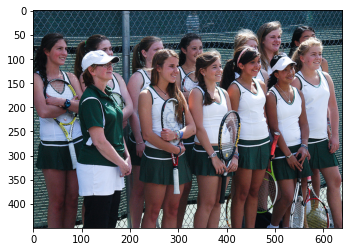

In [49]:
img_name = random.choice(os.listdir("/content/train2014"))
image_path = os.path.join(main_img_path, img_name)

predict_caption(captionNet, image_path)

Caption: <BOS> skier growth skier growth skier growth skier growth skier growth skier growth skier growth skier growth skier growth skier


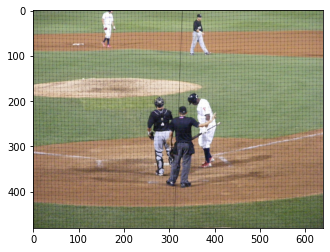

In [50]:
img_name = random.choice(os.listdir("/content/train2014"))
image_path = os.path.join(main_img_path, img_name)

predict_caption(captionNet, image_path)